Train long short term memory discriminative model (LSTM) to evaluate the label quality produced by EMERGE. The following shows training LSTM on one dataset.

In [1]:
import sys, os, glob
import pandas as pd
import numpy as np
import random

from sklearn import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
from utils import get_full_path

In [3]:
DATASET = "RIPE"
db_dir = get_full_path('ripe') # original, raw csv's

# DATASET = "SYNTH" # don't use; use the other evaluation notebook for CAIDA data
# db_dir = get_full_path('MTL', 'data', 'synthetic')

snuba_split_set_dir = get_full_path('snuba', 'data', DATASET, 'input_snuba')
output_dir = get_full_path('snuba', 'data', DATASET, 'results')
labeled_dir = get_full_path('snuba', 'data', DATASET, 'labeled_data') + '/'

# Properly labeled data for dataset XX and feature YY is stored in
#     f"snuba/input_snuba/{labeled_data}/dataset_{index}/{feature}/ ... "

from snuba.data.data_loader import DataLoader
from snuba.program_synthesis.heuristic_generator import HeuristicGenerator
from snuba.program_synthesis.synthesizer import Synthesizer
from snuba.program_synthesis.verifier import Verifier
from snuba.lstm.lstm import *
np.random.seed(42)

os.chdir(db_dir)
datasets = glob.glob('*.csv')
datasets_sorted = sorted(datasets)
# print(datasets_sorted)

In [4]:
# load data backup
# def load_data(client):
def original_load_data(client):
    input_dir = f"{snuba_split_set_dir}/{client[:-4]}" # processed data from snuba/input_snuba/dataset_xx
    os.chdir(input_dir)
    train_original = pd.read_csv(glob.glob('train_original_*')[0])
    val_original = pd.read_csv(glob.glob('val_original_*')[0])
    test_original = pd.read_csv(glob.glob('test_original_*')[0])
    train_probs = np.load(glob.glob('probs_labels*')[0])
    val_ground = np.load(glob.glob('val_ground_*')[0])
    test_ground = np.load(glob.glob('test_ground_*')[0])
    return train_original, val_original, test_original, train_probs, val_ground, test_ground

In [5]:
def load_data(client):
    """ Load NP cached labels and values. """
    global selected_feature
    
    if client.endswith('.csv'):
        client = client[:-4] # trim trailing .csv
    
    # processed data from snuba/input_snuba/dataset_xx/FEATURE/
    input_dir = f"{snuba_split_set_dir}/{client}/{selected_feature}"
    
    print(f"Loaded {selected_feature} data for {client}.")
    
    os.chdir(input_dir)
    train_original = pd.read_csv(glob.glob('train_original_*')[0])
    val_original = pd.read_csv(glob.glob('val_original_*')[0])
    test_original = pd.read_csv(glob.glob('test_original_*')[0])
    
    train_probs = np.load(glob.glob('probs_labels*')[0])
    val_ground = np.load(glob.glob('val_ground_*')[0])
    test_ground = np.load(glob.glob('test_ground_*')[0])
    
    return train_original, val_original, test_original, train_probs, val_ground, test_ground

def load_data_to_active(client):
    """ Wrapper function for loading labels and data from a specific dataset into the active memory for use
        in the validate() and test() functions. """
    global train_original, val_original, test_original, train_probs, val_ground, test_ground, selected_feature, \
            train_data, val_data, test_data
    
    train_original, val_original, test_original, train_probs, val_ground, test_ground = load_data(client)

    train_data = train_original['rtt']
    val_data = val_original['rtt']
    test_data = test_original['rtt']

### `load_data` is defined; Time to load our labels and original RTT values.

In [6]:
selected_feature = 'changepoint' # 'outage', 'congestion', or 'noise'
load_data_to_active(datasets_sorted[0])

Loaded changepoint data for out_000.


In [7]:
def validate(client, num_epochs=20, lr=0.005):
    global train_data, train_probs, val_data, val_ground, selected_feature
    global val_pred # for use in confusion matrices
    
    if client.endswith('.csv'):
        client = client[:-4]
    heuristic = 'emerge'
    
    bs = 128
    n = num_epochs
    num_cells = 128
    l2_reg = 0.05
    dropout_val = 0.0
    
    plt.clf()
    
    y_pred = lstm_simple(train_data, train_probs, val_data, val_ground, client, heuristic,\
                                bs=bs, n=n, num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)
    val_pred = predictions
    
    val_acc = np.sum(predictions == val_ground) / float(np.shape(val_ground)[0])
#     val_f1 = metrics.f1_score(val_ground, predictions, average='micro', zero_division=0)
    val_f1 = metrics.f1_score(val_ground, predictions, average='micro')
#     val_pr = metrics.precision_score(val_ground, predictions, average='micro', zero_division=0)
#     val_re = metrics.recall_score(val_ground, predictions, average='micro', zero_division=0)

    val_pr = metrics.precision_score(val_ground, predictions, average='micro')
    val_re = metrics.recall_score(val_ground, predictions, average='micro')


    print (f'======= EMERGE Validation Results on {client} for {selected_feature} =======')
    print ('Validation Accuracy: ', val_acc)
    print ('Validation F1 Score: ', val_f1)
    print ('Validation Best Pr: ', val_pr)
    print ('Validation Best Re: ', val_re)
    
    return val_acc


In [8]:
def test(client, num_epochs=20, lr=0.005):
    global train_data, train_probs, test_data, test_ground, selected_feature
    global test_pred # for use in confusion matrices
    
    if client.endswith('.csv'):
        client = client[:-4]
    heuristic = 'emerge'
    
    results_dir = output_dir+'/'+str(client)
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    os.chdir(results_dir)
    
    # Take RTT data for train, val, and test set
    train_data = train_original['rtt']
    val_data = val_original['rtt']
    test_data = test_original['rtt']

    print ('... Train LSTM ...')

    bs = 128
    n = num_epochs
    num_cells = 128
    l2_reg = 0.05
    dropout_val = 0.0
    early_stopping_epoch = n
    
    plt.clf()
    
    # Train model.
    y_pred = lstm_simple(train_data, train_probs, test_data, test_ground, client, heuristic,\
                            bs=bs, n=n, num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)
    test_pred = predictions

    # Test accuracy is the number of predictions that match the test_ground truth, divided by the number of entries
    test_acc = np.sum(predictions == test_ground) / float(np.shape(test_ground)[0])
    
    print ('=================================================================')
    print ('      EMERGE Test Results on', client, "for", selected_feature)
    print ('=================================================================')
    print( 'Test Accuracy: ', test_acc)
    test_f1 = metrics.f1_score(test_ground, predictions, average='micro')
    print ('Test F1 Score: ', test_f1)
#     print ('Test Precision: ', metrics.precision_score(test_ground, predictions, average='micro', zero_division=0))
#     print ('Test Recall: ', metrics.recall_score(test_ground, predictions, average='micro', zero_division=0))
    print ('Test Precision: ', metrics.precision_score(test_ground, predictions, average='micro'))
    print ('Test Recall: ', metrics.recall_score(test_ground, predictions, average='micro'))
    
    return test_f1


In [ ]:
# Set active client
# client = datasets_sorted[0] # validation: 98.85%, test: 99.8%
# client = datasets_sorted[1] # validation: 99.9%, test: 100%

# original method
# train_original, val_original, test_original, train_probs, val_ground, test_ground = original_load_data(client)
# train_data = train_original['rtt']
# val_data = val_original['rtt']
# test_data = test_original['rtt']


# load_data_to_active(client, feature='noise') # newly labeled

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix_dir = get_full_path('MTL', 'Figures', 'stl', 'ripe')

def gen_confusion_matrix(predictions, truth, index : int, display=True, save=False, prefix="", filetype="png"):
    """ Wrapper function for SKLearn confusion matrix metric. Returns a dictionary containing the confusion matrix values. """
    global selected_feature
    assert len(predictions) == len(truth)
    matrix = confusion_matrix(predictions, truth)
    
    TN, FP, FN, TP = matrix.ravel()
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FP)
    precision = TP / (TP + FP)
    F1 = (2 * precision * recall) / (precision + recall)
    
    conf_matrix = {
        "TP": TP,
        "FN": FN,
        "FP": FP,
        "TN": TN,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": F1
    }
    
    if display:
        feat = selected_feature
        if selected_feature == "outage":
            feat = 'loss'
            
        # Heatmap implementation from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
        plt.clf()
        if index != "":
            plt.suptitle(f"STL {index:02d} Confusion Matrix")
        plt.title(f"Feature: {feat.capitalize()}", fontsize="small")
#         group_names = ['True Pos','False Pos','False Neg','True Neg']
        group_names = ['True Neg','False Neg','False Pos','True Pos']
        group_counts = ["Count: {0:0.0f}".format(value) for value in matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten() / np.sum(matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        plt.xlabel(f'True Label\nF1 Score: {round(F1, 5)}')
        plt.ylabel('Predicted Label')
        
        plt.rcParams["figure.dpi"] = 150
        
        ax = sns.heatmap(matrix, annot=labels, fmt="", cmap='Blues', cbar=True, square=True, \
                    xticklabels=[0, 1], yticklabels=[0, 1], edgecolors="b")
#                     xticklabels=[1, 0], yticklabels=[1, 0], edgecolors="b")
        
        for _, spine in ax.spines.items(): # add black borders around heatmap
            spine.set_visible(True)
        
        if save:
            # save figure to figures dir
            plt.savefig(f"{conf_matrix_dir}/{feat}/{prefix}dataset_{index:02d}.{filetype}", bbox_inches="tight")
    return conf_matrix

#### NEW confusion matrix generation

In [10]:
# selected_feature = 'noise'
# selected_feature = 'outage'
# selected_feature = 'congestion'

client = datasets_sorted[0]
# validate(client)
# test(client)

Loaded congestion data for out_000.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 19600 samples, validate on 4900 samples
Epoch 1/20
19600/19600 [==============================] - 12s 600us/step - loss: 3.6890 - accuracy: 0.0000e+00 - val_loss: 1.5563 - val_accuracy: 0.4890
Epoch 2/20
19600/19600 [==============================] - 11s 565us/step - loss: 0.9932 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.4245
Epoch 3/20
19600/19600 [==============================] - 11s 555us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.6435
Epoch 4/20
19600/19600 [==============================] - 11s 564us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.3243
Epoch 5/20
19600/19600 [==============================] - 11s 575us/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.69

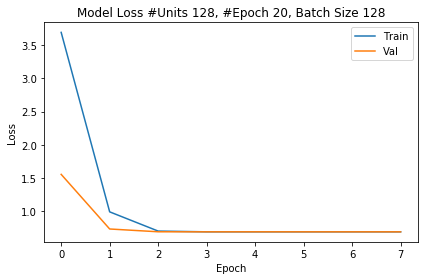

Accuracy: 27.14%
======= EMERGE Validation Results on out_000 for congestion =======
Validation Accuracy:  0.2714285714285714
Validation F1 Score:  0.2714285714285714
Validation Best Pr:  0.2714285714285714
Validation Best Re:  0.2714285714285714
Validation Complete.

Testing...  
... Train LSTM ...
Train on 19600 samples, validate on 500 samples
Epoch 1/20
19600/19600 [==============================] - 11s 539us/step - loss: 3.7007 - accuracy: 0.0000e+00 - val_loss: 1.5561 - val_accuracy: 0.4120
Epoch 2/20
19600/19600 [==============================] - 10s 521us/step - loss: 0.9929 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.6120
Epoch 3/20
19600/19600 [==============================] - 10s 515us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.3460
Epoch 4/20
19600/19600 [==============================] - 10s 511us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.4140
Epoch 5/20
19600/19600 [===============

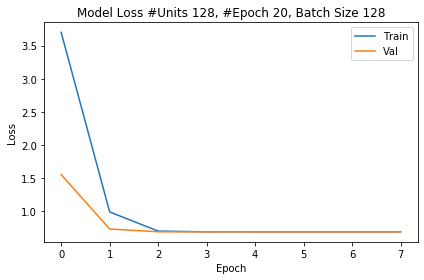

Accuracy: 39.40%
      EMERGE Test Results on out_000 for congestion
Test Accuracy:  0.394
Test F1 Score:  0.394
Test Precision:  0.394
Test Recall:  0.394
Loaded congestion data for out_001.
Train on 19600 samples, validate on 4900 samples
Epoch 1/20
19600/19600 [==============================] - 12s 596us/step - loss: 3.6890 - accuracy: 0.0000e+00 - val_loss: 1.5564 - val_accuracy: 0.4302
Epoch 2/20
19600/19600 [==============================] - 11s 565us/step - loss: 0.9932 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.4245
Epoch 3/20
19600/19600 [==============================] - 11s 572us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.2602
Epoch 4/20
19600/19600 [==============================] - 11s 559us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.3853
Epoch 5/20
19600/19600 [==============================] - 11s 552us/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0

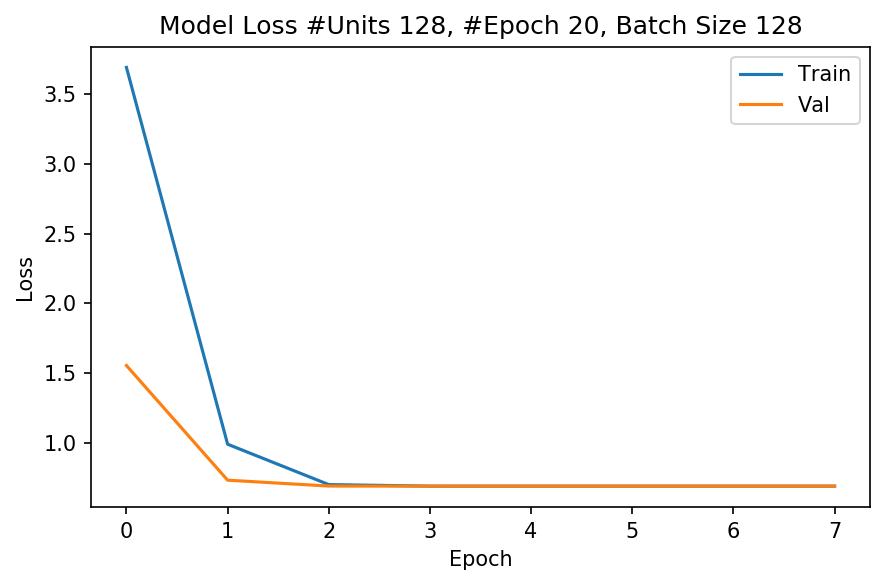

Accuracy: 55.04%
======= EMERGE Validation Results on out_001 for congestion =======
Validation Accuracy:  0.5502040816326531
Validation F1 Score:  0.5502040816326531
Validation Best Pr:  0.5502040816326531
Validation Best Re:  0.5502040816326531
Validation Complete.

Testing...  
... Train LSTM ...
Train on 19600 samples, validate on 500 samples
Epoch 1/20
19600/19600 [==============================] - 11s 536us/step - loss: 3.7008 - accuracy: 0.0000e+00 - val_loss: 1.5561 - val_accuracy: 0.6280
Epoch 2/20
19600/19600 [==============================] - 10s 515us/step - loss: 0.9929 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.5380
Epoch 3/20
19600/19600 [==============================] - 10s 507us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.4600
Epoch 4/20
19600/19600 [==============================] - 10s 509us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.5780
Epoch 5/20
19600/19600 [===============

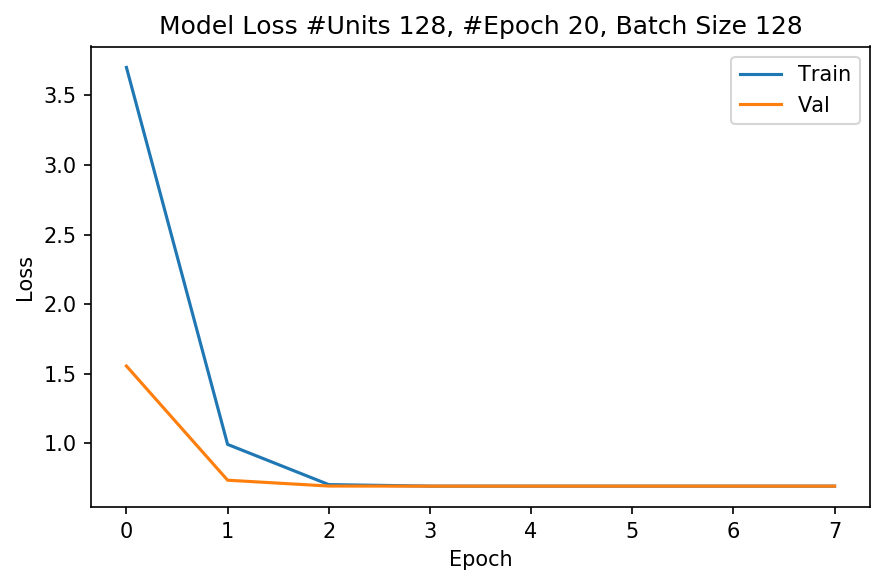

Accuracy: 45.80%
      EMERGE Test Results on out_001 for congestion
Test Accuracy:  0.458
Test F1 Score:  0.458
Test Precision:  0.458
Test Recall:  0.458
Loaded congestion data for out_002.
Train on 19600 samples, validate on 4900 samples
Epoch 1/20
19600/19600 [==============================] - 12s 606us/step - loss: 3.6893 - accuracy: 0.0000e+00 - val_loss: 1.5563 - val_accuracy: 0.5347
Epoch 2/20
19600/19600 [==============================] - 11s 579us/step - loss: 0.9932 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.4733
Epoch 3/20
19600/19600 [==============================] - 11s 578us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.7720
Epoch 4/20
19600/19600 [==============================] - 12s 593us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.6906
Epoch 5/20
19600/19600 [==============================] - 12s 594us/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0

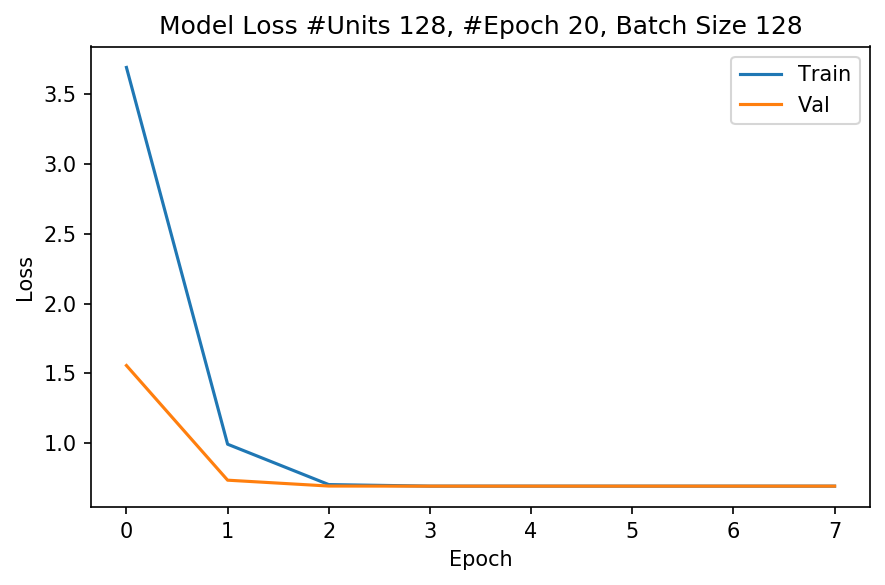

Accuracy: 28.12%
======= EMERGE Validation Results on out_002 for congestion =======
Validation Accuracy:  0.28122448979591835
Validation F1 Score:  0.28122448979591835
Validation Best Pr:  0.28122448979591835
Validation Best Re:  0.28122448979591835
Validation Complete.

Testing...  
... Train LSTM ...
Train on 19600 samples, validate on 500 samples
Epoch 1/20
19600/19600 [==============================] - 11s 541us/step - loss: 3.7007 - accuracy: 0.0000e+00 - val_loss: 1.5560 - val_accuracy: 0.5920
Epoch 2/20
19600/19600 [==============================] - 10s 504us/step - loss: 0.9929 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.2800
Epoch 3/20
19600/19600 [==============================] - 10s 507us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.3880
Epoch 4/20
19600/19600 [==============================] - 10s 516us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.6140
Epoch 5/20
19600/19600 [===========

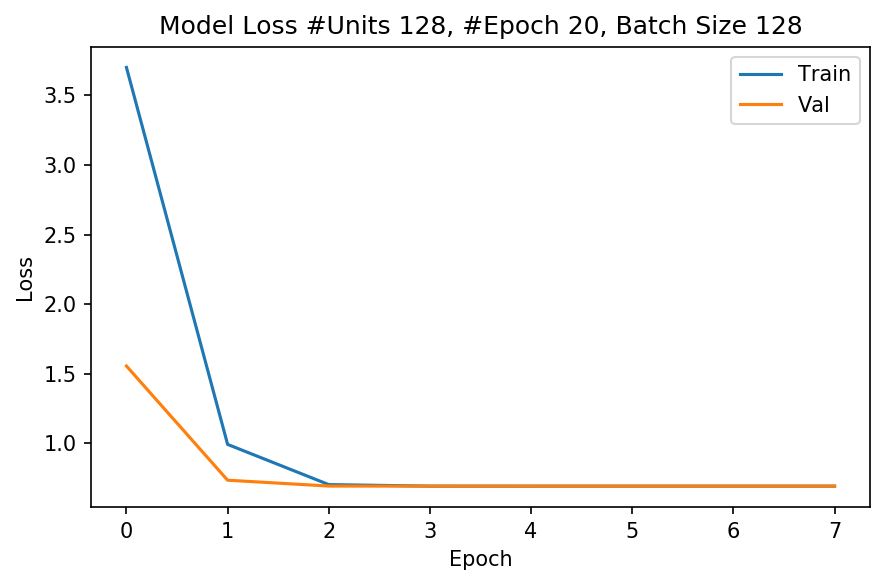

Accuracy: 40.60%
      EMERGE Test Results on out_002 for congestion
Test Accuracy:  0.406
Test F1 Score:  0.40599999999999997
Test Precision:  0.406
Test Recall:  0.406
Loaded congestion data for out_003.
Train on 19600 samples, validate on 4900 samples
Epoch 1/20
19600/19600 [==============================] - 12s 602us/step - loss: 3.6891 - accuracy: 0.0000e+00 - val_loss: 1.5563 - val_accuracy: 0.5561
Epoch 2/20
19600/19600 [==============================] - 11s 567us/step - loss: 0.9932 - accuracy: 0.0000e+00 - val_loss: 0.7358 - val_accuracy: 0.5135
Epoch 3/20
19600/19600 [==============================] - 11s 577us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.5371
Epoch 4/20
19600/19600 [==============================] - 11s 566us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.4971
Epoch 5/20
19600/19600 [==============================] - 11s 569us/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6931 - v

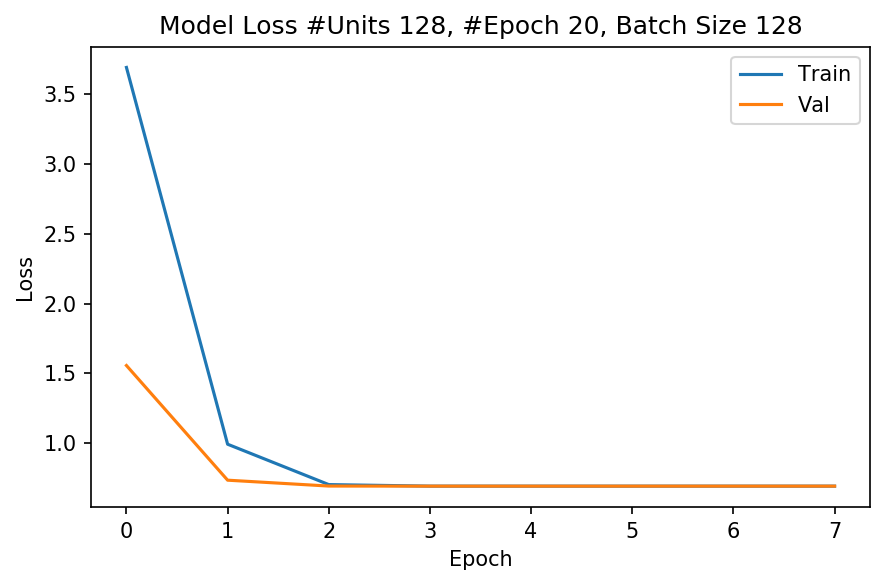

Accuracy: 63.59%
======= EMERGE Validation Results on out_003 for congestion =======
Validation Accuracy:  0.6355102040816326
Validation F1 Score:  0.6355102040816326
Validation Best Pr:  0.6355102040816326
Validation Best Re:  0.6355102040816326
Validation Complete.

Testing...  
... Train LSTM ...
Train on 19600 samples, validate on 500 samples
Epoch 1/20
19600/19600 [==============================] - 11s 551us/step - loss: 3.7007 - accuracy: 0.0000e+00 - val_loss: 1.5561 - val_accuracy: 0.4900
Epoch 2/20
19600/19600 [==============================] - 10s 520us/step - loss: 0.9929 - accuracy: 0.0000e+00 - val_loss: 0.7359 - val_accuracy: 0.4540
Epoch 3/20
19600/19600 [==============================] - 11s 538us/step - loss: 0.7043 - accuracy: 0.0000e+00 - val_loss: 0.6938 - val_accuracy: 0.3580
Epoch 4/20
19600/19600 [==============================] - 10s 535us/step - loss: 0.6933 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_accuracy: 0.5360
Epoch 5/20
19600/19600 [===============

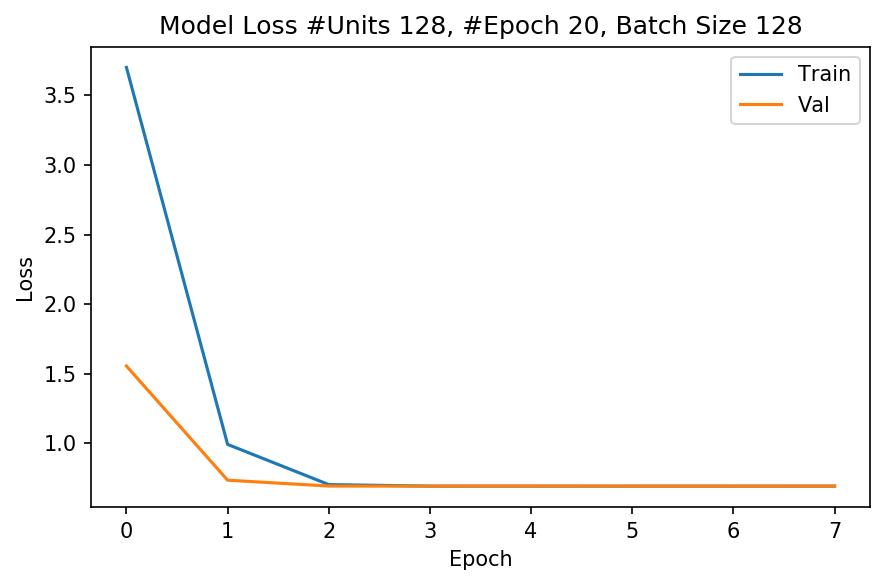

Accuracy: 29.00%
      EMERGE Test Results on out_003 for congestion
Test Accuracy:  0.29
Test F1 Score:  0.29
Test Precision:  0.29
Test Recall:  0.29
Loaded congestion data for out_004.


FileNotFoundError: [Errno 2] No such file or directory: '/home/jared/arisenlp/arise/snuba/data/RIPE/input_snuba/out_004/congestion'

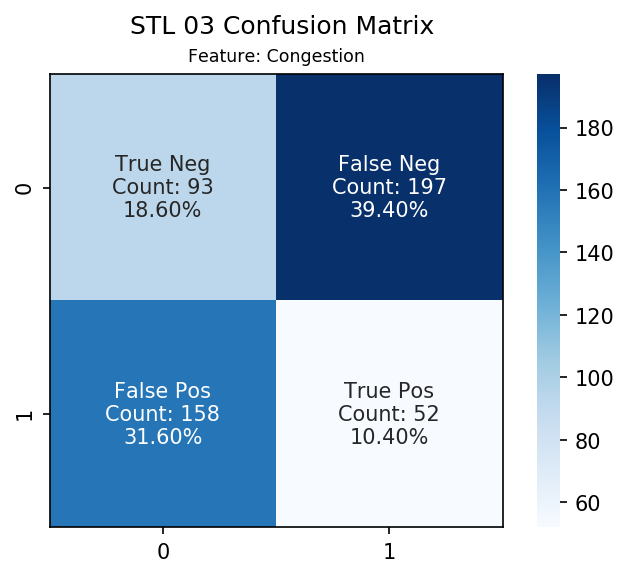

In [11]:
from timeit import default_timer as timer
global val_pred, test_pred, selected_feature

validations = []
tests = []

val_times = []
test_times = []
total_times = []

results = []

clients = datasets_sorted # can operate on any of the 28 datasets.

features = ['outage', 'congestion', 'noise', 'changepoint']

# selected_feature = 'outage'
selected_feature = 'congestion'
# selected_feature = 'noise'
# selected_feature = 'changepoint'

for client in clients[:14]:
    EPOCHS = 20 # default 20
    LR = 0.005 # default 0.005
    
    num = int(client[-6:-4]) # get number but not csv from dataset
    
    load_data_to_active(client) # load data for this client
#     try:
#         load_data_to_active(client) # load data for this client
#     except:
#         print("Error loading data for", client)
    
    start = timer() # get current time for measurement analysis
    
#     try:
    val = validate(client, num_epochs=EPOCHS, lr=LR) # validate
#     except:
#         print(f"Error validating client {client} for {selected_feature}.")
#         continue
        
    end_val = timer()
    
#     gen_confusion_matrix(val_pred, val_ground, index=num, display=True, save=True, prefix="val_", filetype="svg")
    
    print("Validation Complete.\n\nTesting...  ")
    
    gen_confusion_matrix(val_pred, val_ground, index=num, display=True, save=False, prefix="", filetype="png")
    
    test_val = test(client, num_epochs=EPOCHS, lr=LR)
    end_test = timer()
    
    val_times.append(round(end_val - start, 5))
    test_times.append(round(end_test - end_val, 5))
    total_times.append(round(end_test - start, 5)) # round duration to 5 decimal places
    
#     gen_confusion_matrix(test_pred, test_ground, index=num, display=True, save=True, prefix="test_", filetype="png")
    gen_confusion_matrix(test_pred, test_ground, index=num, display=True, save=False, prefix="labeled_", filetype="png")
    
#     conf = gen_confusion_matrix(test_pred, test_ground, index=num, filetype="png", save=True, \
#                                  selected_feature=selected_feature, pre="", useTitle=True) # generate matrix and save to
                                                                    # root/MTL/Figures/stl/<feature>/dataset_xx.png
    
    # Store results
    validations.append(val)
    tests.append(test_val)
    results.append((val, test_val))


In [ ]:
# gen_confusion_matrix(test_pred, test_ground, index=num, display=True, save=True, prefix="", filetype="png")

In [12]:
import statistics # for calculating avg. run times
from math import sqrt
precision = 5
print(f"#### Feature: `{selected_feature}`  ")
print(f"Average Validation Score: `{statistics.mean(i[0] for i in results)}`  ")
print(f"Average Test Score: `{statistics.mean(i[1] for i in results)}`  ")
print(f"Validation, Test scores:  \n`{results}`  \n")
print(f"#### Total Time: `{round(sum(total_times) / 60, precision)}` minutes  ")
# print(f"Average Total Time: `{round(statistics.mean(total_times), precision)}` seconds  ")
# print(f"#### Average Validation Time: `{round(sum(val_times) / len(val_times), precision)}` seconds  \n`{val_times}`  ", \
#       f"\n#### Average Test Time:  `{round(sum(test_times) / len(test_times), precision)}` seconds  \n`{test_times}`  \n", \
#        "___________________________________  ")
print(f"#### Average Validation Time: `{round(sum(val_times) / len(val_times), precision)}` seconds  \n", \
      f"\n#### Average Test Time:  `{round(sum(test_times) / len(test_times), precision)}` seconds  ", \
      f"\n#### Average Total Time: `{round(sum(test_times) / len(test_times) + sum(val_times) / len(val_times), 5)}` seconds  \n"
       "___________________________________  ")


# print(f"Test st.  dev: {statistics.stdev([i[1] for i in results])}")
# print(f"Test variance: {statistics.variance([i[1] for i in results])}")

#### Feature: `congestion`  
Average Validation Score: `0.43459183673469387`  
Average Test Score: `0.387`  
Validation, Test scores:  
`[(0.2714285714285714, 0.394), (0.5502040816326531, 0.458), (0.28122448979591835, 0.40599999999999997), (0.6355102040816326, 0.29)]`  

#### Total Time: `22.20517` minutes  
#### Average Validation Time: `233.72643` seconds  
 
#### Average Test Time:  `99.35104` seconds   
#### Average Total Time: `333.07747` seconds  
___________________________________  


In [28]:
""" Writing results to disk: """
import json

# print(bak)
# bak = stl_results
# stl_results = bak

# filename = "stl_results_RIPE" # pre changepoint

# filename = "stl_RIPE" # combined w/ changepoint

filename = "ripe_revised"

stl_results = {}
try:
    with open(get_full_path('MTL', 'data') + f"/{filename}.json", "r") as f:
        stl_results = json.load(f)
except:
    stl_results = {}

noise = results.copy()
noise_val_times = val_times
noise_test_times = test_times
noise_val_scores = [a[0] for a in noise]
noise_test_scores = [a[1] for a in noise]

if selected_feature == "outage":
    selected_feature = "loss"

stl_results[selected_feature] = {"Test": list(zip(noise_test_scores, noise_test_times)), 
                        "Validation": list(zip(noise_val_scores, noise_val_times)), 
                        "Total Time": round(sum(test_times) / len(test_times) + sum(val_times) / len(val_times), 5)
                       }

from pprint import pprint
pprint(stl_results)


# with open(get_full_path('MTL', 'data') + "/stl_results.json", "w") as outfile:
with open(get_full_path('MTL', 'data') + f"/{filename}.json", "w") as outfile:
    json.dump(stl_results, outfile, indent=2)


{'changepoint': {'Test': [(0.548, 158.13435),
                          (0.488, 158.71584),
                          (0.482, 151.70473)],
                 'Total Time': 362.05654,
                 'Validation': [(0.42081632653061224, 206.26449),
                                (0.46816326530612246, 205.26013),
                                (0.47061224489795916, 206.09007)]},
 'congestion': {'Test': [[0.608, 146.31003],
                         [0.774, 147.57488],
                         [0.49, 148.29446],
                         [0.552, 148.50494]],
                'Total Time': 344.01962,
                'Validation': [[0.5512244897959183, 194.25658],
                               [0.5126530612244898, 195.84926],
                               [0.49673469387755104, 196.32788],
                               [0.6077551020408163, 198.96045]]},
 'loss': {'Test': [[0.706, 179.07956],
                   [0.508, 144.93882],
                   [0.456, 145.81305],
                   [0.

In [ ]:
stl_results